## 文本处理

In [1]:
with open('sentiment_dic/nagtive_dic_2.txt', 'r') as f:  # 替换成实际的文件名
    content = f.read().strip()  # 读取文件内容并去掉首尾空格
words = content.split('、')  # 将内容按顿号分割成单独的单词，存入列表中

with open('sentiment_dic/nagtive_dic_2.txt', 'w') as f:  # 替换成实际的文件名
    for word in words:
        f.write(word + '\n')  # 将每个单词写入文件，并换行

In [2]:
# 读取第一个txt文件
with open('sentiment_dic/nagtive_dic_1.txt', 'r') as f1:
    content1 = f1.read().strip()  # 读取文件内容并去掉首尾空格
words1 = content1.split('\n')  # 将内容按换行符分割成单独的单词，存入列表中

# 读取第二个txt文件
with open('sentiment_dic/nagtive_dic_2.txt', 'r') as f2:
    content2 = f2.read().strip()  # 读取文件内容并去掉首尾空格
words2 = content2.split('\n')  # 将内容按换行符分割成单独的单词，存入列表中

# 合并两个列表并去除重复的内容
words = list(set(words1 + words2))

# 将内容写入新的txt文件
with open('negative_dic_combined.txt', 'w') as f:
    for word in words:
        f.write(word + '\n')  # 将每个单词写入文件，并换行

## 情感值计算demo

In [9]:
import jieba
import json

# 加载情感词典
with open('sentiment_dic/senti_dic_pro.txt', 'r', encoding='utf-8') as f:
    sentiment_dict = json.load(f)

# 加载程度副词词典
with open('sentiment_dic/adv_dic.txt', 'r', encoding='utf-8') as f:
    degree_dict = json.load(f)

# 加载否定词词典
with open('sentiment_dic/neg_dic.txt', 'r', encoding='utf-8') as f:
    negation_dict = json.load(f)
    
# 计算单个句子的情感分数
def sentiment_score(sen):
    seg_list = jieba.cut(sen)  # 分词
    seg_list = list(seg_list)
    print(seg_list)
    emotion_score = 0  # 情感分数
    neg_count = 0  # 否定词数量
    for i in range(len(seg_list)):
        # 检查情感词
        if seg_list[i] in sentiment_dict:
            score = sentiment_dict[seg_list[i]]
            degree_score = 1  # 默认程度系数为1
            negation_score = 1  # 默认否定系数为1
            # 在有效距离内寻找程度副词和否定词
            for j in range(max(0, i-3), i):
                if seg_list[j] in degree_dict:
                    degree_score *= degree_dict[seg_list[j]]
                elif seg_list[j] in negation_dict:
                    neg_count += 1
            # 根据否定词数量判断情感分数是否反转
            if neg_count % 2 == 0:
                emotion_score += score * degree_score
            else:
                emotion_score -= score * degree_score
            neg_count = 0  # 重置否定词数量
    return emotion_score

In [10]:
# 测试代码
sen = '我非常开心，甚至极其开心'
score = sentiment_score(sen)
print(score)

Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/st/jr2134cd02575p7pnq8xy5440000gn/T/jieba.cache
Loading model cost 0.323 seconds.
Prefix dict has been built successfully.


['我', '非常', '开心', '，', '甚至', '极其', '开心']
8


In [13]:
# 测试代码
sen = '很难过'
score = sentiment_score(sen)
print(score)

['很', '难过']
-3.0


In [12]:
# 测试代码
sen = '绝对很好'
score = sentiment_score(sen)
print(score)

['绝对', '很', '好']
6.0


In [115]:
# 测试代码
sen = '我好开心'
score = sentiment_score(sen)
print(score)

['我', '好开心']
0


In [116]:
# 测试代码
sen = '我挺好的'
score = sentiment_score(sen)
print(score)

['我', '挺', '好', '的']
1.6


## LDA最优主题数获取

In [23]:
import os
import csv
import warnings
import time

import numpy as np
import matplotlib.pyplot as plt

import gensim
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from gensim.models import CoherenceModel
import pyLDAvis.gensim

from sklearn.metrics.pairwise import cosine_similarity

warnings.filterwarnings('ignore')


In [24]:
def plot_perplexity(num_topics_range, perplexity_values, save_dir, file_name):
    plt.plot(num_topics_range, perplexity_values)
    plt.xlabel('Number of Topics')
    plt.ylabel('Perplexity')
    plt.title('Perplexity vs Number of Topics')
    plt.savefig(os.path.join(save_dir, file_name))
    plt.show()
    plt.close()

def plot_coherence_scores(num_topics_range, coherence_scores, save_dir, file_name):
    plt.plot(num_topics_range, coherence_scores)
    plt.xlabel('Number of Topics')
    plt.ylabel('Coherence Score')
    plt.title('Coherence Score vs Number of Topics')
    plt.savefig(os.path.join(save_dir, file_name))
    plt.show()
    plt.close()

def get_optimal_topic_num_by_perplexity(file_path, num_topics_range, save_dir):
    '''
    Compute the optimal number of topics.

    Parameters:
    file_path: str, the file path of the preprocessed text file.
    num_topics_range: list, the range of topic numbers to try.
    save_dir: str, the directory path to save the generated plots.

    Returns:
    best_num_topics: int, the optimal number of topics.
    '''

    # Read the file and create the corpus
    with open(file_path, 'r', encoding='utf-8') as f:
        corpus = [line.strip().split() for line in f]

    # Create the dictionary
    dictionary = Dictionary(corpus)

    # Train the LDA models with different topic numbers, and calculate the perplexity values
    perplexity_values = []
    lda_models = []
    for num_topics in num_topics_range:
        lda_model = LdaModel(corpus=[dictionary.doc2bow(text) for text in corpus], id2word=dictionary, num_topics=num_topics)
        lda_models.append(lda_model)
        perplexity_values.append(lda_model.log_perplexity([dictionary.doc2bow(text) for text in corpus]))

    # Generate unique file names based on current timestamp
    timestamp = str(time.time()).replace('.', '')  # Unique timestamp
    perplexity_file_name = f'perplexity_plot_{timestamp}.svg'
    coherence_file_name = f'coherence_plot_{timestamp}.svg'

    # Save the perplexity plot and coherence plot as vector images
    plot_perplexity(num_topics_range, perplexity_values, save_dir, perplexity_file_name)

    # Calculate the coherence scores using the perplexity values
    coherence_scores = [CoherenceModel(model=lda_model, texts=corpus, dictionary=dictionary, coherence='c_v').get_coherence() for lda_model in lda_models]

    # Save the coherence plot as a vector image
    plot_coherence_scores(num_topics_range, coherence_scores, save_dir, coherence_file_name)

    # Find the optimal number of topics based on the coherence scores
    best_num_topics_index = coherence_scores.index(max(coherence_scores))
    best_num_topics = num_topics_range[best_num_topics_index]
    
    print("Optimal number of topics (using perplexity method):", best_num_topics)

    return best_num_topics

In [25]:
def plot_similarity(num_topics_range, similarity_values, save_dir, file_name):
    plt.plot(num_topics_range, similarity_values)
    plt.xlabel('Number of Topics')
    plt.ylabel('Average Cosine Similarity')
    plt.title('Average Cosine Similarity vs Number of Topics')
    plt.savefig(os.path.join(save_dir, file_name))
    plt.show()
    plt.close()

def get_optimal_topic_num_by_similarity(file_path, num_topics_range, save_dir):
    '''
    Compute the optimal number of topics.

    Parameters:
    file_path: str, the file path of the preprocessed text file.
    num_topics_range: list, the range of topic numbers to try.
    save_dir: str, the directory path to save the generated plots.

    Returns:
    best_num_topics: int, the optimal number of topics.
    '''

    # Read file and create corpus
    with open(file_path, 'r', encoding='utf-8') as f:
        corpus = [line.strip().split() for line in f]

    # Create dictionary
    dictionary = gensim.corpora.Dictionary(corpus)

    # Train LDA model and compute cosine similarity between topics for different number of topics
    similarity_values = []
    for num_topics in num_topics_range:
        lda_model = gensim.models.ldamodel.LdaModel(corpus=[dictionary.doc2bow(text) for text in corpus], id2word=dictionary, num_topics=num_topics)
        topics_matrix = lda_model.get_topics()
        cosine_similarities = cosine_similarity(topics_matrix)
        similarity_values.append(np.mean(cosine_similarities[np.triu_indices(num_topics, k=1)]))

    # Generate a unique file name based on current timestamp
    timestamp = str(time.time()).replace('.', '')  # Unique timestamp
    file_name = f'similarity_plot_{timestamp}.svg'

    # Save the similarity plot as a vector image
    plot_similarity(num_topics_range, similarity_values, save_dir, file_name)

    # Find the optimal number of topics
    best_num_topics_index = similarity_values.index(min(similarity_values))
    best_num_topics = num_topics_range[best_num_topics_index]
    
    print("Optimal number of topics (using cosine similarity method):", best_num_topics)
    
    return best_num_topics

In [26]:
# Create a list of integers for the range of number of topics.
num_topics_range = list(range(3, 20))
save_dir = "../images/Optimal_topics_number_search"

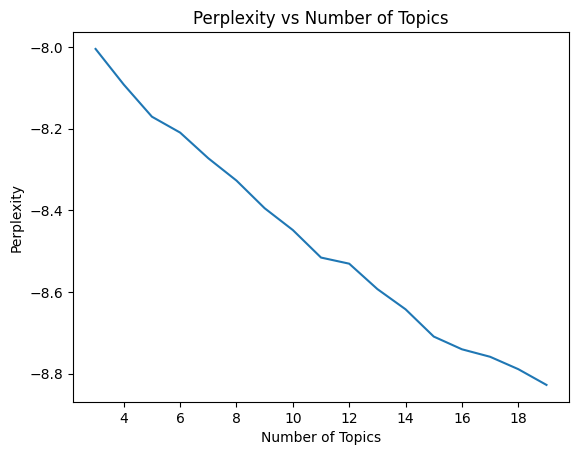

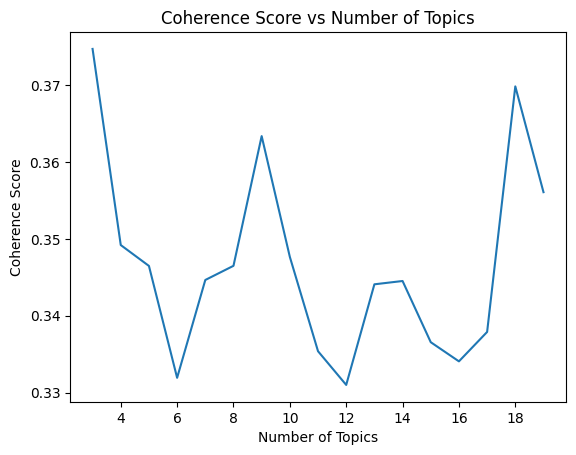

Optimal number of topics (using perplexity method): 3


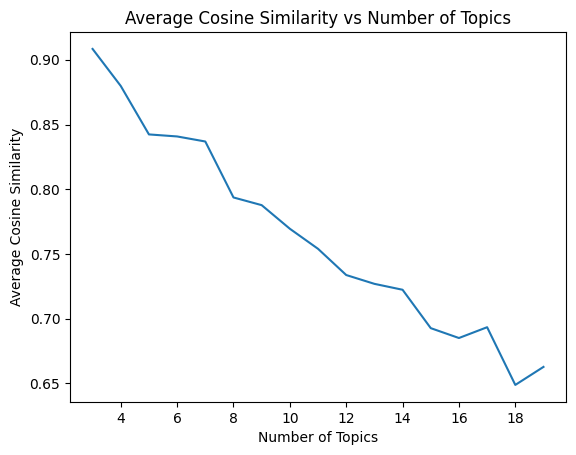

Optimal number of topics (using cosine similarity method): 18
Ultimate optimal number of topics : 10


In [27]:
# Set the file path for a text file.
file_path = "../data/review/analysis/polarity/reviews_1_polarity_N.txt"

# Get the optimal number of topics based on perplexity and cosine similarity.
best_num_topics_perplexity = get_optimal_topic_num_by_perplexity(file_path, num_topics_range, save_dir)
best_num_topics_similarity = get_optimal_topic_num_by_similarity(file_path, num_topics_range, save_dir)

# Print the ultimate optimal number of topics.
N1_best_num_topics = int((best_num_topics_perplexity + best_num_topics_similarity)/2)
print("Ultimate optimal number of topics :", N1_best_num_topics)

## 代码行数统计

In [28]:
import os
import re

def count_code_lines(file_path):
    code_count = 0
    comment_count = 0
    with open(file_path, 'r', encoding='utf-8') as file:
        lines = file.readlines()
        is_in_comment = False
        for line in lines:
            stripped_line = line.strip()
            if stripped_line:
                if stripped_line.startswith('#'):
                    comment_count += 1
                else:
                    if re.search(r'#', stripped_line):
                        comment_count += 1
                    code_count += 1
    return code_count, comment_count

def count_total_lines(folder_path):
    total_code_count = 0
    total_comment_count = 0
    for file in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file)
        if file.endswith('.ipynb') and os.path.isfile(file_path):
            code_count, comment_count = count_code_lines(file_path)
            total_code_count += code_count
            total_comment_count += comment_count
            print(f"{file_path}: Code lines: {code_count}, Comment lines: {comment_count}")
    print(f"Total Code lines: {total_code_count}")
    print(f"Total Comment lines: {total_comment_count}")

current_directory = os.getcwd()
count_total_lines(current_directory)


/Users/colemei/Desktop/Graduation Design/source/Data-Analysis-02.ipynb: Code lines: 1373, Comment lines: 91
/Users/colemei/Desktop/Graduation Design/source/Data-PreProcessing-01.ipynb: Code lines: 727, Comment lines: 94
/Users/colemei/Desktop/Graduation Design/source/Data-Analysis-01.ipynb: Code lines: 1106, Comment lines: 150
/Users/colemei/Desktop/Graduation Design/source/Data-Analysis-03.ipynb: Code lines: 452, Comment lines: 40
/Users/colemei/Desktop/Graduation Design/source/Content-Mining-01.ipynb: Code lines: 1477, Comment lines: 100
/Users/colemei/Desktop/Graduation Design/source/Data-Cleaning-02.ipynb: Code lines: 1421, Comment lines: 62
/Users/colemei/Desktop/Graduation Design/source/Others.ipynb: Code lines: 578, Comment lines: 58
/Users/colemei/Desktop/Graduation Design/source/Data-Storage-01.ipynb: Code lines: 163, Comment lines: 20
/Users/colemei/Desktop/Graduation Design/source/Data-Cleaning-01.ipynb: Code lines: 501, Comment lines: 5
Total Code lines: 7798
Total Comment 